# Libraries

In [1]:
# load libraries
import os
import warnings
import time
import gc
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib.metadata
import seaborn as sns

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV


from verstack import NaNImputer
from sklearn.impute import SimpleImputer

import mlflow
from mlflow.models import infer_signature

import pickle

import shap

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

re - 2.2.1
numpy - 1.24.3
pandas - 2.0.3
seaborn - 0.12.2
NaNImputer - 2.0.0
mlflow - 2.13.2
shap - 0.44.1
matplotlib -  3.7.2


In [4]:
from jyquickhelper import add_notebook_menu

# Add the table of contents
add_notebook_menu()  

## MLFlow Tracker setup

Pour initialiser le serveur :   

In [5]:
print('-'*120)
print(' ')
print('Pour initialiser le serveur, rentrer cette commande dans le terminal :')
print(' ')
print('mlflow server --host 127.0.0.1 --port 8080')
print(' ')
print('-'*120)

------------------------------------------------------------------------------------------------------------------------
 
Pour initialiser le serveur, rentrer cette commande dans le terminal :
 
mlflow server --host 127.0.0.1 --port 8080
 
------------------------------------------------------------------------------------------------------------------------


In [6]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080/")
mlflow.set_experiment("Credit Score models")

<Experiment: artifact_location='mlflow-artifacts:/509629842382284046', creation_time=1719330594729, experiment_id='509629842382284046', last_update_time=1719330594729, lifecycle_stage='active', name='Credit Score models', tags={}>

## 0. Functions

In [7]:
def cost_function(TN, TP, FP, FN):
    return 10 * TN + TP - 10 * FP - 100 * FN

In [8]:
def graph_results(y_prob_pred) : 
    
    """"
    This function returns ; AUC score, max_cost (Maximum reached by cost function), optimal_threshold 
                                                                                        (threshold to reach max_cost)
    
    It also displays those numbers, and plots the ROC curve and the cost function graph
    
    Only argument needed is the prediction of probability.
    Other notations are supposed to be conventional (y_test)
    """
    
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_pred)

    # Calculate the AUC score
    roc_auc = roc_auc_score(y_test, y_prob_pred)

    # Initialize lists to store costs and thresholds
    costs = []
    thresholds = np.arange(0, 1.001, 0.001)

    # Calculate the cost for each threshold
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = cost_function(tn, tp, fp, fn)
        costs.append(cost)

    # Convert costs to a numpy array for easy manipulation
    costs = np.array(costs)

    # Find the maximum cost and the corresponding threshold
    max_cost_index = np.argmax(costs)
    max_cost = costs[max_cost_index]
    optimal_threshold = thresholds[max_cost_index]
    

    # Print the maximum cost and the corresponding threshold

    print(' ')
    print('-'*125)
    print(' ')
    print(f'Maximum Cost: {max_cost}')
    print(f'Optimal Threshold: {optimal_threshold}')
    print(' ')
    print('-'*125)
    print(' ')

    # Find the FPR and TPR for the optimal threshold
    optimal_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Plot the ROC curve and highlight the optimal point
    plt.figure(figsize=(7.5, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter([optimal_fpr], [optimal_tpr], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}', zorder=5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(' ')
    print('-'*125)
    print(' ')

    # Plot the cost function
    plt.figure(figsize=(15, 6))  # Adjust the size to be more horizontally rectangular
    plt.plot(thresholds, costs, label='Cost Function')
    plt.scatter([optimal_threshold], [max_cost], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Cost')
    plt.title('Cost Function vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return  roc_auc, max_cost, optimal_threshold

## 1. First models

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
df = pd.read_csv(r'./merged_data/df_train.csv')

In [11]:
df.set_index('SK_ID_CURR', inplace=True)

In [12]:
print('Shape of df :', df.shape)

Shape of df : (307506, 173)


In [13]:
#Replace inf values with max values

max_value = np.nanmax(df['CC_DRAWING_LIMIT_RATIO_MAX'][df['CC_DRAWING_LIMIT_RATIO_MAX'] != np.inf])
df['CC_DRAWING_LIMIT_RATIO_MAX'].replace([np.inf, -np.inf], max_value, inplace=True)

max_value = np.nanmax(df['INSTAL_PAYMENT_RATIO_MEAN'][df['INSTAL_PAYMENT_RATIO_MEAN'] != np.inf])
df['INSTAL_PAYMENT_RATIO_MEAN'].replace([np.inf, -np.inf], max_value, inplace=True)

max_value = np.nanmax(df['CC_PAYMENT_DIV_MIN_MIN'][df['CC_PAYMENT_DIV_MIN_MIN'] != np.inf])
df['CC_PAYMENT_DIV_MIN_MIN'].replace([np.inf, -np.inf], max_value, inplace=True)

max_value = np.nanmax(df['INSTAL_PAYMENT_RATIO_MEAN'][df['INSTAL_PAYMENT_RATIO_MEAN'] != np.inf])
df['INSTAL_PAYMENT_RATIO_MEAN'].replace([np.inf, -np.inf], max_value, inplace=True)

In [14]:
df_sample, _ = train_test_split(df, train_size=70000, stratify=df['TARGET'], random_state=42)

In [15]:
print('Shape of df_sample :', df_sample.shape)

Shape of df_sample : (70000, 173)


Let's work first with df_sample to save on computing time

In [16]:
X = df_sample.drop(columns=['TARGET'])
y = df_sample['TARGET']

feature_names = X.columns

# Impute missing values using mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

### 1.1 Baseline

In [17]:
params = {
    'n_estimators': 100,
    'max_depth': 20,
    'random_state': 42
}

rf_clf = RandomForestClassifier(**params)

rf_clf.fit(X_train, y_train)

y_prob = rf_clf.predict_proba(X_test)
y_prob = y_prob[:, 1]

 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 30397
Optimal Threshold: 0.178
 
-----------------------------------------------------------------------------------------------------------------------------
 


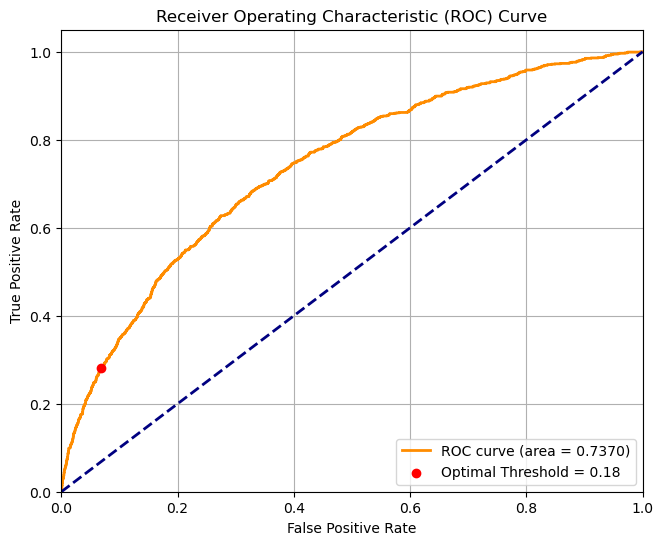

 
-----------------------------------------------------------------------------------------------------------------------------
 


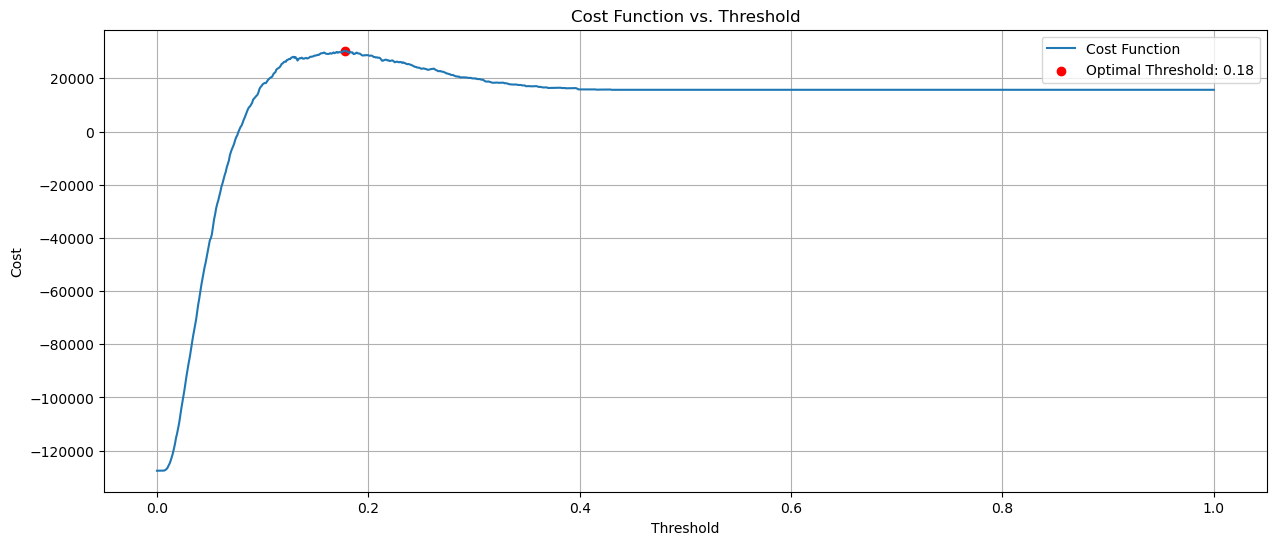

In [18]:
roc_auc_baseline, max_cost_baseline, optimal_threshold_baseline = graph_results(y_prob)

In [19]:
# Start an MLflow run
with mlflow.start_run(run_name="baseline"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_baseline)
    mlflow.log_metric("max_cost", max_cost_baseline)
    mlflow.log_metric("optimal_threshold", optimal_threshold_baseline)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Setting a baseline for metrics, with an easy model")

    # Infer the model signature
    signature = infer_signature(X_train, rf_clf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf_clf,
        signature=signature,
        artifact_path="random_forest_baseline",
        input_example=X_train,
        registered_model_name="baseline",
    )

Registered model 'baseline' already exists. Creating a new version of this model...
2024/06/25 17:58:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: baseline, version 4
Created version '4' of model 'baseline'.


### 1.2 XGBoost RandomSearch

In [20]:
# Define the simplified parameter grid
param_grid = {
    'n_estimators': [1000, 2000, 5000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 15, 20],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=55
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and best AUC score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Use the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best AUC score:  0.7695037435705299


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 39987
Optimal Threshold: 0.098
 
-----------------------------------------------------------------------------------------------------------------------------
 


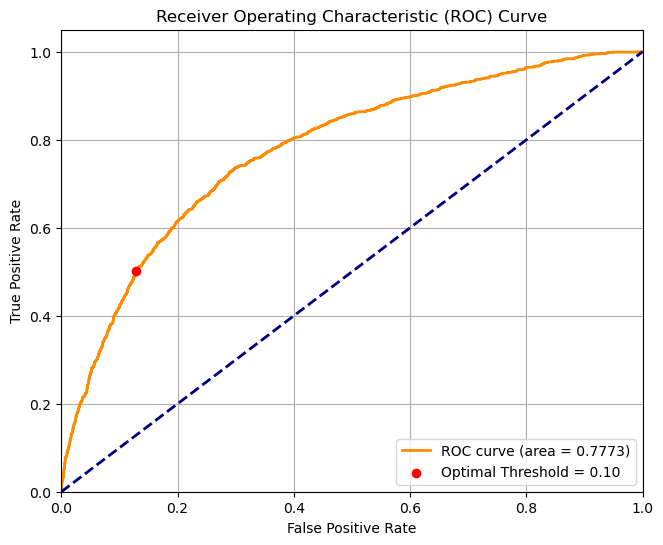

 
-----------------------------------------------------------------------------------------------------------------------------
 


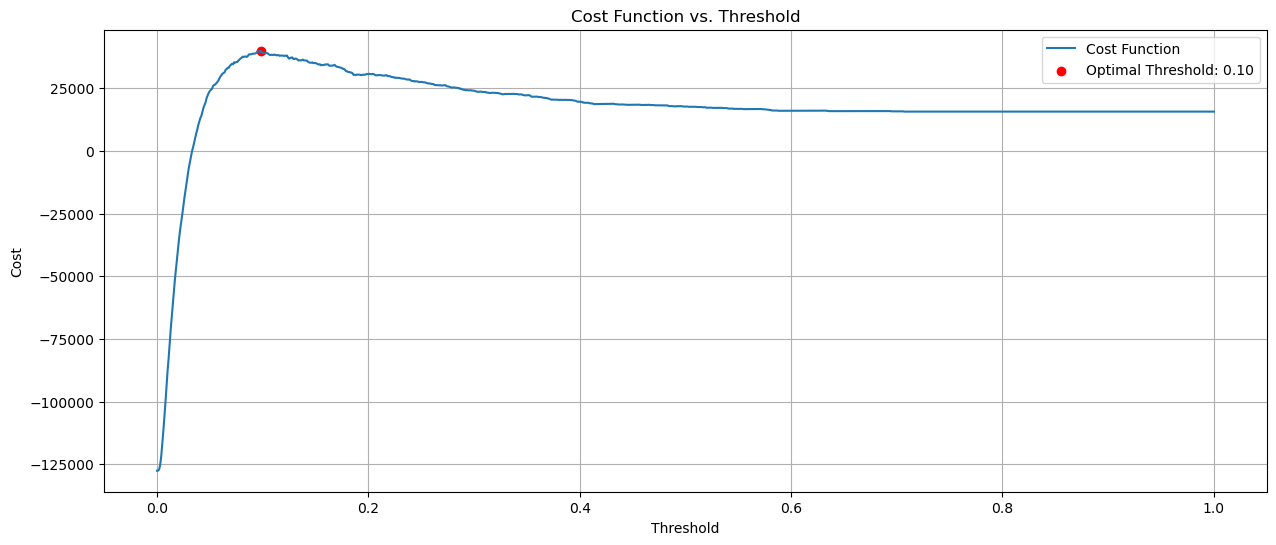

In [21]:
roc_auc_xgbsearch, max_cost_xgbsearch, optimal_threshold_xgbsearch = graph_results(y_prob)

In [22]:
# Start an MLflow run
with mlflow.start_run(run_name="best_xgboost_search"):
    # Log the hyperparameters
    mlflow.log_params(random_search.best_params_)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_xgbsearch)
    mlflow.log_metric("max_cost", max_cost_xgbsearch)
    mlflow.log_metric("optimal_threshold", optimal_threshold_xgbsearch)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Best params and metrics from a RandomSearch with XGBoostClassifier")

    # Infer the model signature
    signature = infer_signature(X_train, random_search.best_estimator_.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=best_model,
        signature=signature,
        artifact_path="xgb_search_best",
        input_example=X_train,
        registered_model_name="xgb_search_best",
    )

Registered model 'xgb_search_best' already exists. Creating a new version of this model...
2024/06/25 18:15:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_search_best, version 4
Created version '4' of model 'xgb_search_best'.


### 1.3 LightGBM RandomSearch

In [23]:
# Define the parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [1000, 2000, 5000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [20, 31, 40],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Initialize the LGBMClassifier
lgb_clf = LGBMClassifier()

# Initialize RandomizedSearchCV for LightGBM
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_grid_lgb,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=55
)

# Fit RandomizedSearchCV for LightGBM
start_time = time.time()
random_search_lgb.fit(X_train, y_train)
total_time = time.time() - start_time
print(f"LightGBM RandomizedSearchCV completed in {total_time:.2f} seconds")

# Print the best parameters and best AUC score for LightGBM
print("Best parameters found for LightGBM: ", random_search_lgb.best_params_)
print("Best AUC score for LightGBM: ", random_search_lgb.best_score_)

# Use the best model for LightGBM
best_model_lgb = random_search_lgb.best_estimator_
y_pred = best_model_lgb.predict(X_test)
y_prob = best_model_lgb.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4521, number of negative: 51479
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22242
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080732 -> initscore=-2.432441
[LightGBM] [Info] Start training from score -2.432441
LightGBM RandomizedSearchCV completed in 884.91 seconds
Best parameters found for LightGBM:  {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 

 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 38295
Optimal Threshold: 0.107
 
-----------------------------------------------------------------------------------------------------------------------------
 


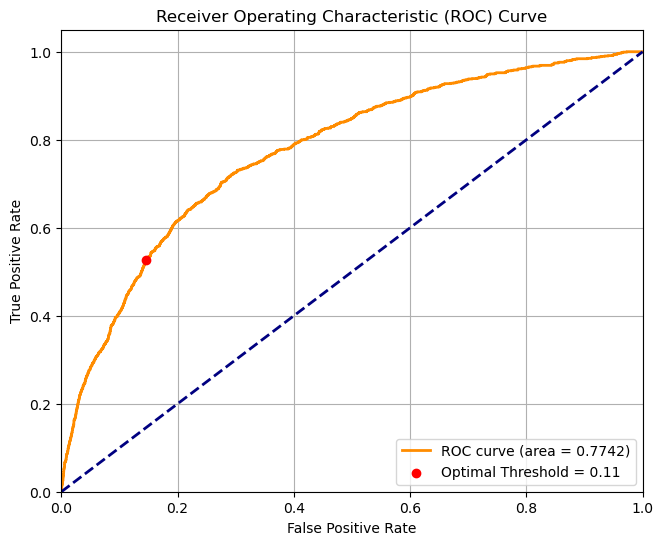

 
-----------------------------------------------------------------------------------------------------------------------------
 


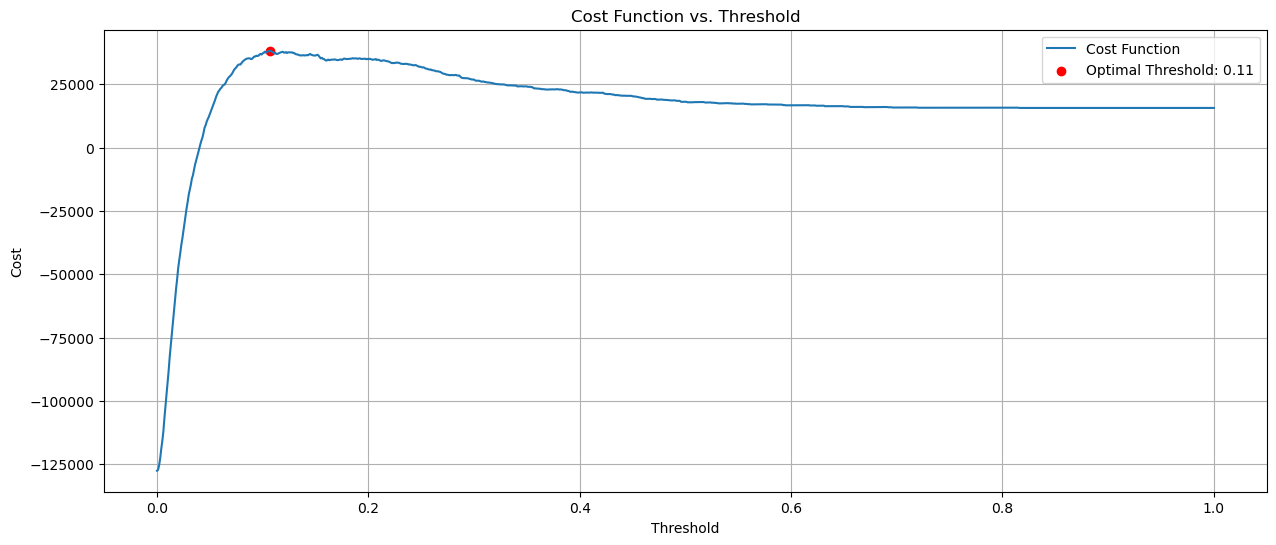

In [24]:
roc_auc_gbmsearch, max_cost_gbmsearch, optimal_threshold_gbmsearch = graph_results(y_prob)

In [25]:
# Start an MLflow run
with mlflow.start_run(run_name="best_lightgbm_search"):
    # Log the hyperparameters
    mlflow.log_params(random_search_lgb.best_params_)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_gbmsearch)
    mlflow.log_metric("max_cost", max_cost_gbmsearch)
    mlflow.log_metric("optimal_threshold", optimal_threshold_gbmsearch)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Best params and metrics from a RandomSearch with LightGBM")

    # Infer the model signature
    signature = infer_signature(X_train, best_model_lgb.predict(X_train))

    # Log the model
    model_info = mlflow.lightgbm.log_model(
        lgb_model=best_model_lgb,
        signature=signature,
        artifact_path="lightgbm_search_best",
        input_example=X_train,
        registered_model_name="lightgbm_search_best",
    )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Registered model 'lightgbm_search_best' already exists. Creating a new version of this model...
2024/06/25 18:32:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm_search_best, version 4
Created version '4' of model 'lightgbm_search_best'.


### 1.4 Catboost RandomSearch

Tous les classifiers se valent à peu près suite à cette random search. Le catboost a été beaucoup plus long. Donc nous allons rester sur le LightGBM, qui semble proposer des résulats plus rapides.  

Maintenant, nous allons essayer d'affiner le modèle, notamment en appliquant plusieurs méthodes :  
    - Hyperparameter tuning & regularization (fait en partie, nous allons tenter d'améliorer)  
    - gérer les problèmes de déséquilibres de classe (avec la méthode SMOTE pour faire du oversampling, et en pondérant les classes)    
    - en testant différents types d'imputers  

Pour chacune de ces évolutions, nous allons mesurer l'AOC, et une fonction de coût que nous allons construire. Cette fonction de coût est adaptée à l'approche métier et prend en en compte l'importance de minimiser les faux négatifs.

### 1.5 Modèle retenu - model1

In [26]:
# Define the model
params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 11,
    'colsample_bytree': 0.6,
    'subsample': 0.7,
    'reg_alpha': 3.5,
    'reg_lambda': 5,
    'min_child_weight': 6,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'verbosity': 1
}

xgb_clf = XGBClassifier(**params)

In [27]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.30615
[100]	validation_0-logloss:0.26591
[200]	validation_0-logloss:0.25176
[300]	validation_0-logloss:0.24622
[400]	validation_0-logloss:0.24351
[500]	validation_0-logloss:0.24191
[600]	validation_0-logloss:0.24118
[700]	validation_0-logloss:0.24068
[800]	validation_0-logloss:0.24042
[900]	validation_0-logloss:0.24032
[1000]	validation_0-logloss:0.24031
[1100]	validation_0-logloss:0.24037
[1120]	validation_0-logloss:0.24033


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 40927
Optimal Threshold: 0.14
 
-----------------------------------------------------------------------------------------------------------------------------
 


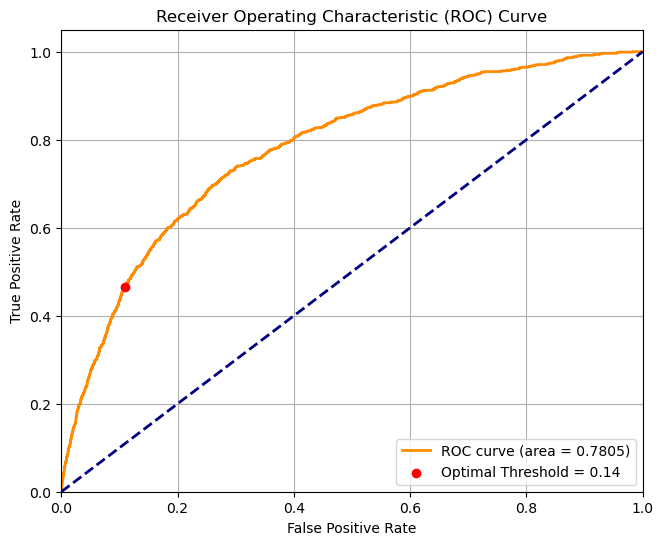

 
-----------------------------------------------------------------------------------------------------------------------------
 


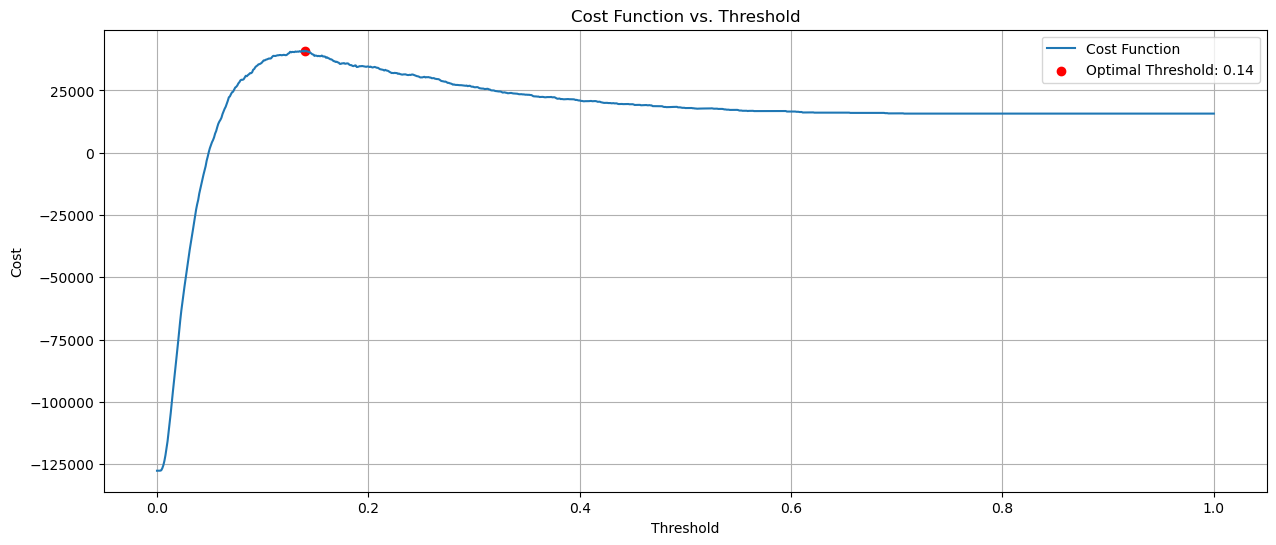

In [28]:
roc_auc_model1, max_cost_model1, optimal_threshold_model1 = graph_results(y_prob)

In [29]:
# Start an MLflow run
with mlflow.start_run(run_name="model1"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model1)
    mlflow.log_metric("max_cost", max_cost_model1)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model1)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Selected model after performing random search")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model1",
        input_example=X_train,
        registered_model_name="model1",
    )

Registered model 'model1' already exists. Creating a new version of this model...
2024/06/25 18:34:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model1, version 4
Created version '4' of model 'model1'.


## 2. Imputers

### 2.1 SimpleImputer - mean - model2

In [30]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

In [31]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.30615
[100]	validation_0-logloss:0.26591
[200]	validation_0-logloss:0.25176
[300]	validation_0-logloss:0.24622
[400]	validation_0-logloss:0.24351
[500]	validation_0-logloss:0.24191
[600]	validation_0-logloss:0.24118
[700]	validation_0-logloss:0.24068
[800]	validation_0-logloss:0.24042
[900]	validation_0-logloss:0.24032
[1000]	validation_0-logloss:0.24031
[1100]	validation_0-logloss:0.24037
[1121]	validation_0-logloss:0.24032


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 40927
Optimal Threshold: 0.14
 
-----------------------------------------------------------------------------------------------------------------------------
 


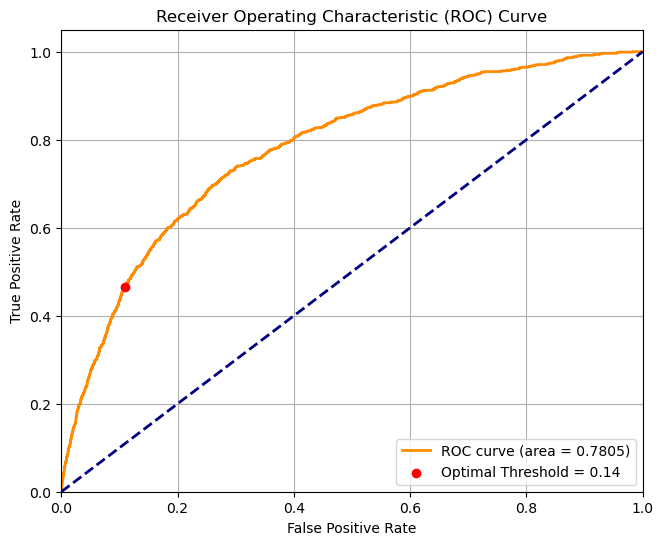

 
-----------------------------------------------------------------------------------------------------------------------------
 


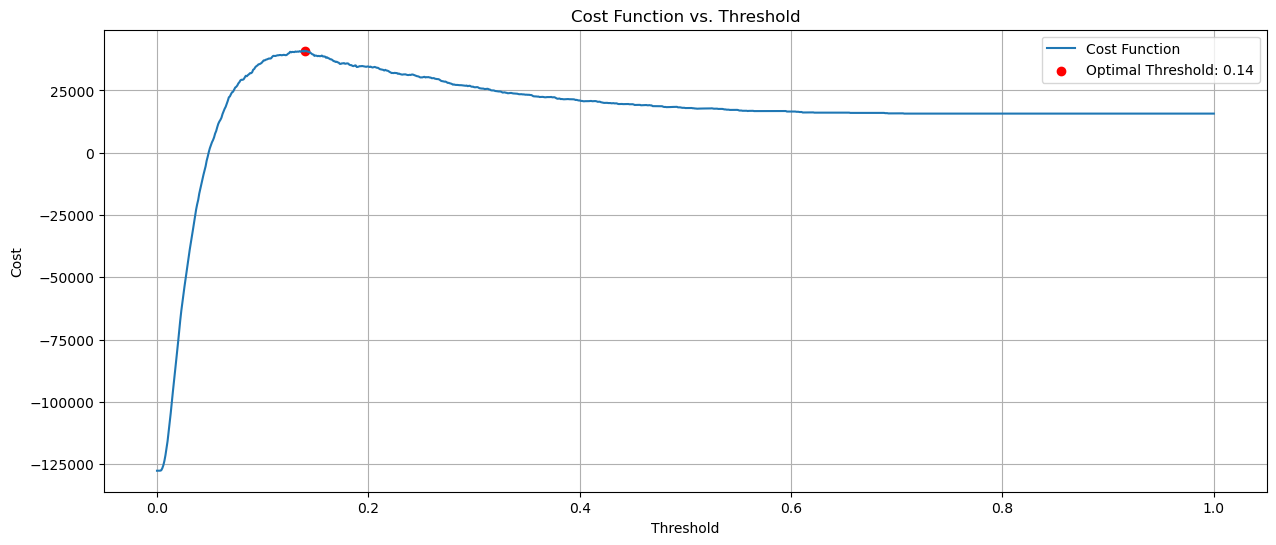

In [33]:
roc_auc_model2, max_cost_model2, optimal_threshold_model2 = graph_results(y_prob)

In [34]:
# Start an MLflow run
with mlflow.start_run(run_name="model2"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model2)
    mlflow.log_metric("max_cost", max_cost_model2)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model2)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "SimpleImputer : mean")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model2",
        input_example=X_train,
        registered_model_name="model2",
    )

Registered model 'model2' already exists. Creating a new version of this model...
2024/06/25 18:36:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model2, version 4
Created version '4' of model 'model2'.


### 2.2 SimpleImputer - median - model3

In [35]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputed = imputer.fit_transform(X)

In [36]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [37]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.30615
[100]	validation_0-logloss:0.26593
[200]	validation_0-logloss:0.25207
[300]	validation_0-logloss:0.24663
[400]	validation_0-logloss:0.24385
[500]	validation_0-logloss:0.24234
[600]	validation_0-logloss:0.24147
[700]	validation_0-logloss:0.24080
[800]	validation_0-logloss:0.24050
[900]	validation_0-logloss:0.24041
[1000]	validation_0-logloss:0.24035
[1042]	validation_0-logloss:0.24040


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 40160
Optimal Threshold: 0.127
 
-----------------------------------------------------------------------------------------------------------------------------
 


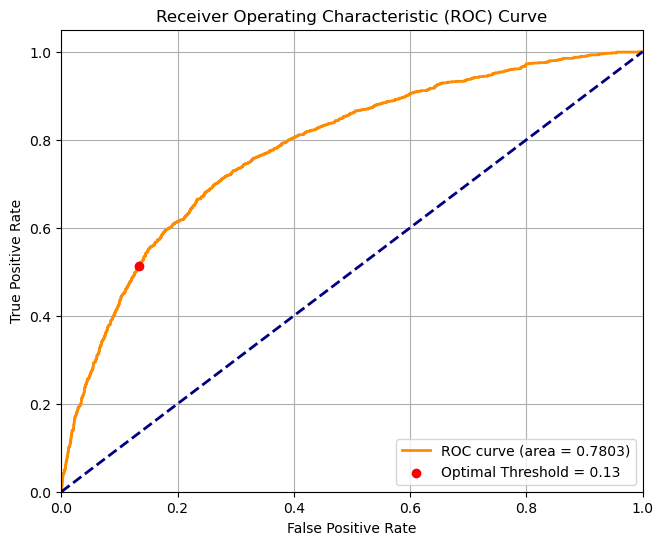

 
-----------------------------------------------------------------------------------------------------------------------------
 


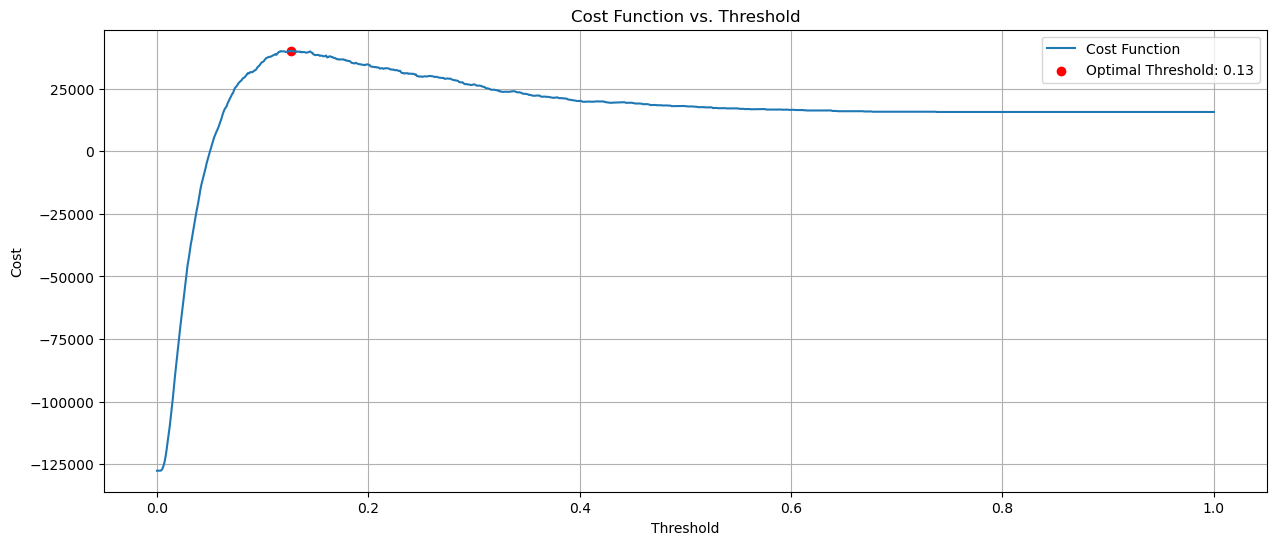

In [38]:
roc_auc_model3, max_cost_model3, optimal_threshold_model3 = graph_results(y_prob)

In [39]:
# Start an MLflow run
with mlflow.start_run(run_name="model3"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model3)
    mlflow.log_metric("max_cost", max_cost_model3)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model3)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "SimpleImputer : median")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model3",
        input_example=X_train,
        registered_model_name="model3",
    )

Registered model 'model3' already exists. Creating a new version of this model...
2024/06/25 18:37:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model3, version 4
Created version '4' of model 'model3'.


### 2.4 KNN Imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
X_imputed = imputer.fit_transform(X)

Remarque : cet imputer est trop long à faire tourner

### 2.5 Verstack - NaNImputer -model4

In [40]:
imputer = NaNImputer()
X_imputed = imputer.impute(X)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         70000
     .. columns:      172
     .. mb in memory: 76.04
     .. NaN cols num: 109

   - Drop hopeless NaN cols

   - droped column CC_DRAWING_LIMIT_RATIO_MAX with NaNs and a constant non-NaN value

   - droped column CC_LAST_AMT_BALANCE_MEAN with NaNs and a constant non-NaN value

   - droped column CC_PAYMENT_DIV_MIN_MIN with NaNs and a constant non-NaN value

   - droped column CC_LATE_PAYMENT_VAR with NaNs and a constant non-NaN value

   - droped column REFUSED_AMT_GOODS_PRICE_MAX with NaNs and a constant non-NaN value

   - droped column CC_AMT_PAYMENT_TOTAL_CURRENT_SUM with NaNs and a constant non-NaN value

   - droped column CC_CNT_DRAWINGS_POS_CURRENT_SUM with NaNs and a constant non-NaN value

   - droped column CC_CNT_DRAWINGS_ATM_CURRENT_SUM with NaNs and a constant non-NaN value

   - droped column ACTIVE_DAYS_CREDIT_VAR with NaNs and a constant non-NaN value

   - droped column ACTIVE_MO

     . Imputed (regression) - 3        NaN in AMT_ANNUITY
     . Imputed (regression) - 9957     NaN in BURO_CREDIT_TYPE_Mortgage_MEAN
     . Imputed (regression) - 66       NaN in AMT_GOODS_PRICE
     . Imputed (regression) - 4002     NaN in APPROVED_CNT_PAYMENT_MEAN
     . Imputed (regression) - 3659     NaN in INSTAL_AMT_PAYMENT_MIN
     . Imputed (regression) - 11671    NaN in BURO_AMT_CREDIT_SUM_DEBT_MEAN

   - Missing values after imputation: 0

Time elapsed for impute execution: 50.04742 seconds


In [41]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.30608
[100]	validation_0-logloss:0.26707
[200]	validation_0-logloss:0.25390
[300]	validation_0-logloss:0.24859
[400]	validation_0-logloss:0.24589
[500]	validation_0-logloss:0.24447
[600]	validation_0-logloss:0.24387
[700]	validation_0-logloss:0.24361
[800]	validation_0-logloss:0.24343
[900]	validation_0-logloss:0.24345
[926]	validation_0-logloss:0.24342


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 38039
Optimal Threshold: 0.14
 
-----------------------------------------------------------------------------------------------------------------------------
 


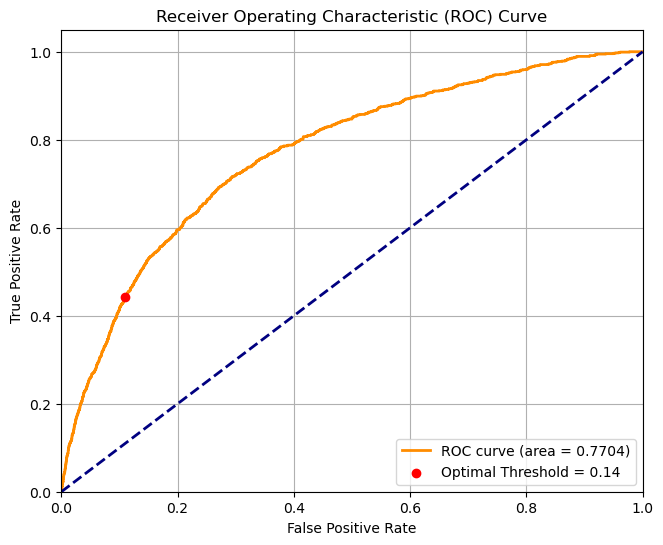

 
-----------------------------------------------------------------------------------------------------------------------------
 


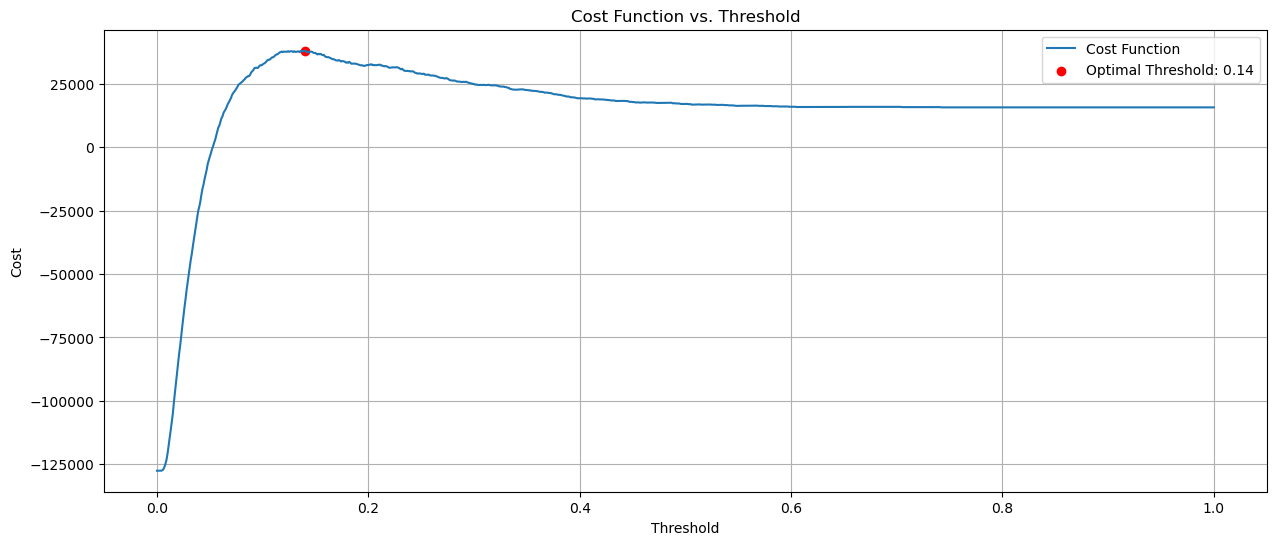

In [43]:
roc_auc_model4, max_cost_model4, optimal_threshold_model4 = graph_results(y_prob)

In [44]:
# Start an MLflow run
with mlflow.start_run(run_name="model4"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model4)
    mlflow.log_metric("max_cost", max_cost_model4)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model4)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Verstack NaNImputer")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model4",
        input_example=X_train,
        registered_model_name="model4",
    )

Registered model 'model4' already exists. Creating a new version of this model...
2024/06/25 18:40:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model4, version 3
Created version '3' of model 'model4'.


Remarque : cet imputer est plus long à faire tourner, et ne paraît pas présenter d'avantages par rapport à un SimpleImputer avec une stratégie mean

#### Conclusion :
On va donc retenir le SimpleImputer, avec la stratégie 'mean'. Celui-ci présente de meilleurs résultats, avec en plus une rapidité et une simplicité accrues

## 3. Class imbalance

##### Benchmark : AUC=0.78 à battre

### 3.1 SMOTE - model5

In [45]:
from imblearn.over_sampling import SMOTE

In [46]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

In [47]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [48]:
# Resampling
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [49]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.68717
[100]	validation_0-logloss:0.39290
[200]	validation_0-logloss:0.30502
[300]	validation_0-logloss:0.27165
[400]	validation_0-logloss:0.25731
[500]	validation_0-logloss:0.25032
[600]	validation_0-logloss:0.24658
[700]	validation_0-logloss:0.24443
[800]	validation_0-logloss:0.24311
[900]	validation_0-logloss:0.24238
[1000]	validation_0-logloss:0.24180
[1100]	validation_0-logloss:0.24158
[1200]	validation_0-logloss:0.24145
[1300]	validation_0-logloss:0.24134
[1400]	validation_0-logloss:0.24129
[1500]	validation_0-logloss:0.24136
[1525]	validation_0-logloss:0.24136


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 39314
Optimal Threshold: 0.161
 
-----------------------------------------------------------------------------------------------------------------------------
 


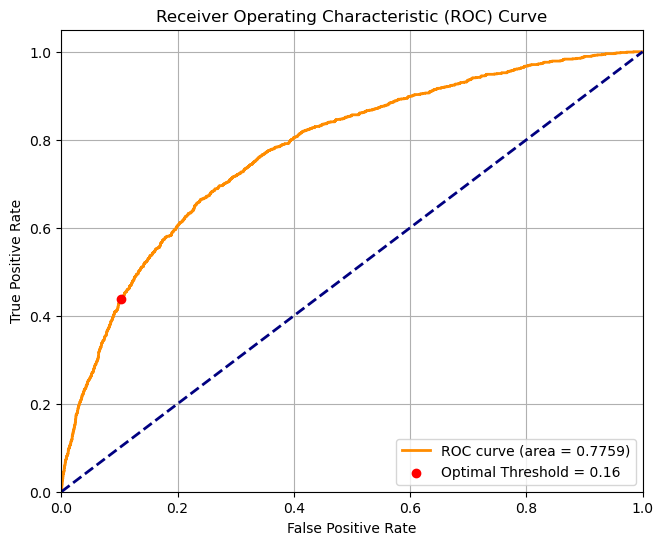

 
-----------------------------------------------------------------------------------------------------------------------------
 


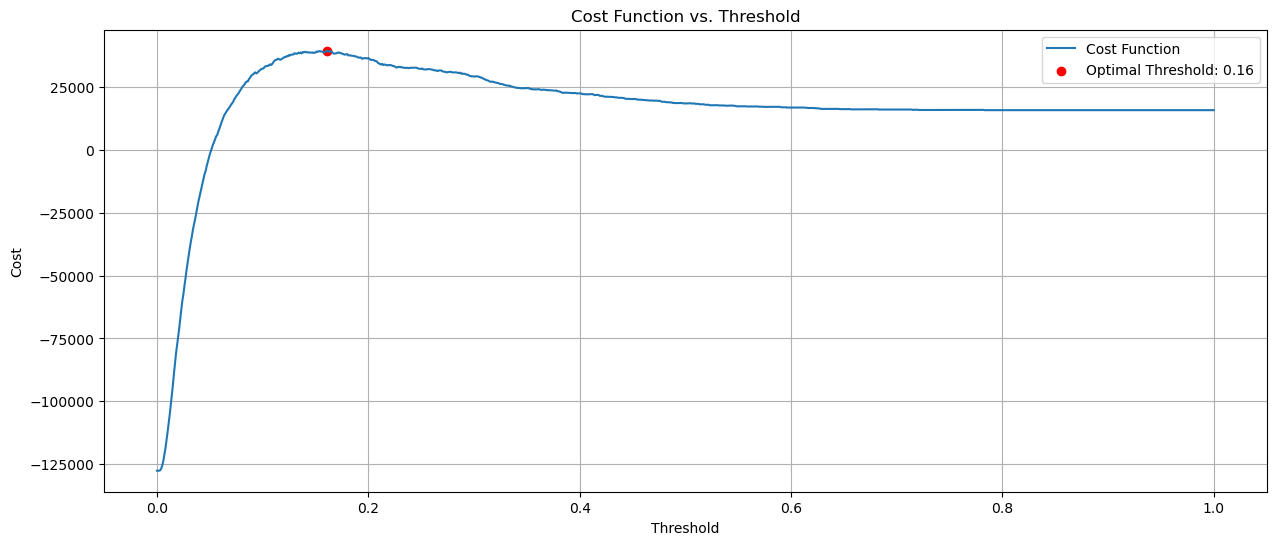

In [50]:
roc_auc_model5, max_cost_model5, optimal_threshold_model5 = graph_results(y_prob)

In [51]:
# Start an MLflow run
with mlflow.start_run(run_name="model5"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model5)
    mlflow.log_metric("max_cost", max_cost_model5)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model5)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "SimpleImputer : mean - SMOTE")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model5",
        input_example=X_train,
        registered_model_name="model5",
    )

Registered model 'model5' already exists. Creating a new version of this model...
2024/06/25 18:43:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model5, version 3
Created version '3' of model 'model5'.


### 3.2 scale_pos_weight argument - model6

In [52]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

In [53]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
# Define the model
params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 11,
    'colsample_bytree': 0.6,
    'subsample': 0.7,
    'reg_alpha': 3.5,
    'reg_lambda': 5,
    'min_child_weight': 6,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'verbosity': 1,
    'scale_pos_weight':8
}

xgb_clf = XGBClassifier(**params)

In [55]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.56023
[100]	validation_0-logloss:0.44425
[200]	validation_0-logloss:0.39196
[300]	validation_0-logloss:0.36280
[400]	validation_0-logloss:0.34488
[500]	validation_0-logloss:0.33100
[600]	validation_0-logloss:0.31903
[700]	validation_0-logloss:0.30913
[800]	validation_0-logloss:0.30063
[900]	validation_0-logloss:0.29277
[1000]	validation_0-logloss:0.28581
[1100]	validation_0-logloss:0.27996
[1200]	validation_0-logloss:0.27479
[1300]	validation_0-logloss:0.27070
[1400]	validation_0-logloss:0.26671
[1500]	validation_0-logloss:0.26340
[1600]	validation_0-logloss:0.26068
[1700]	validation_0-logloss:0.25803
[1800]	validation_0-logloss:0.25614
[1900]	validation_0-logloss:0.25455
[2000]	validation_0-logloss:0.25296
[2100]	validation_0-logloss:0.25183
[2200]	validation_0-logloss:0.25087
[2300]	validation_0-logloss:0.25000
[2400]	validation_0-logloss:0.24939
[2500]	validation_0-logloss:0.24888
[2600]	validation_0-logloss:0.24853
[2700]	validation_0-logloss:0.24829
[280

 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 38182
Optimal Threshold: 0.14200000000000002
 
-----------------------------------------------------------------------------------------------------------------------------
 


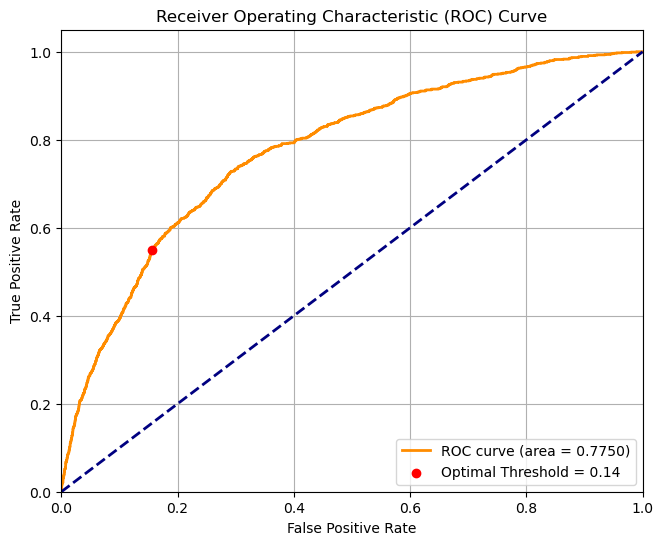

 
-----------------------------------------------------------------------------------------------------------------------------
 


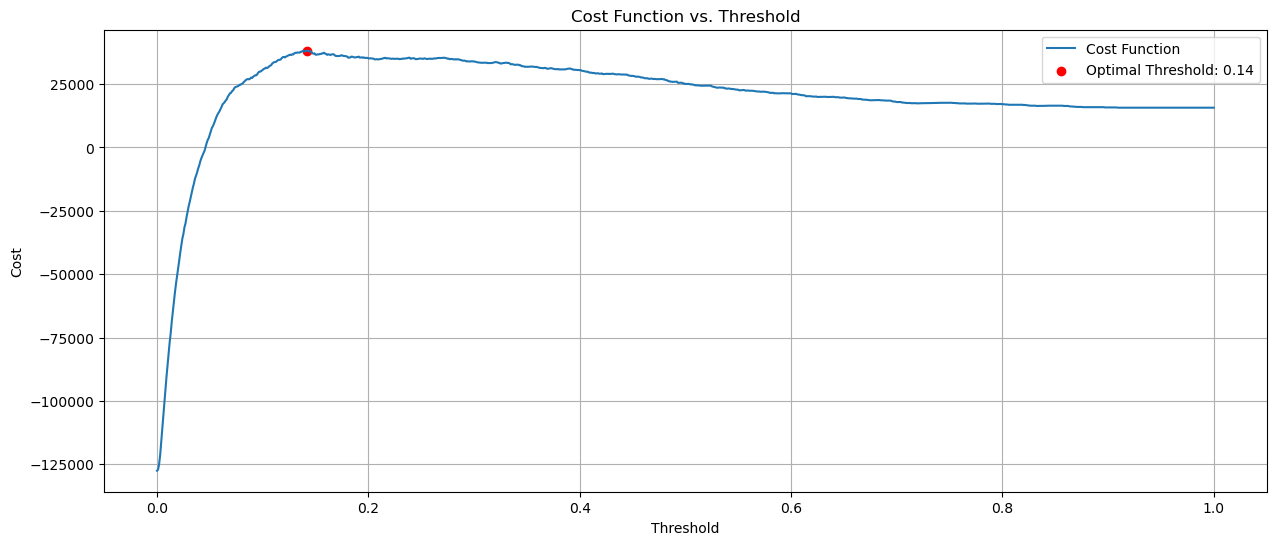

In [56]:
roc_auc_model6, max_cost_model6, optimal_threshold_model6 = graph_results(y_prob)

In [57]:
# Start an MLflow run
with mlflow.start_run(run_name="model6"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metrics
    mlflow.log_metric("roc_auc", roc_auc_model6)
    mlflow.log_metric("max_cost", max_cost_model6)
    mlflow.log_metric("optimal_threshold", optimal_threshold_model6)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "SimpleImputer : mean - scale_pos_weight")

    # Infer the model signature
    signature = infer_signature(X_train, xgb_clf.predict(X_train))

    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_clf,
        signature=signature,
        artifact_path="model6",
        input_example=X_train,
        registered_model_name="model6",
    )

Registered model 'model6' already exists. Creating a new version of this model...
2024/06/25 18:47:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model6, version 3
Created version '3' of model 'model6'.


##### REMARQUE : l'algo met plus longtemps à converger, et le résultat semble légèrement moins bon

## 4. Feature importance

### 4.1 Modèle retenu

Après évaluation des différents paramètres, le modèle présentant les meilleures metrics, notamment en prenant en compte le coût métier des faux négatifs, est le model1.  
C'est celui-ci que l'on utilisera désormais, sur le dataframe global, pour étudier la feature importance, locale ou globale.

In [58]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Impute missing values using mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [59]:
# Define the model
params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 11,
    'colsample_bytree': 0.6,
    'subsample': 0.7,
    'reg_alpha': 3.5,
    'reg_lambda': 5,
    'min_child_weight': 6,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'verbosity': 1
}

xgb_clf = XGBClassifier(**params)

In [60]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=100)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.30614
[100]	validation_0-logloss:0.26346
[200]	validation_0-logloss:0.24911
[300]	validation_0-logloss:0.24356
[400]	validation_0-logloss:0.24098
[500]	validation_0-logloss:0.23956
[600]	validation_0-logloss:0.23870
[700]	validation_0-logloss:0.23807
[800]	validation_0-logloss:0.23769
[900]	validation_0-logloss:0.23737
[1000]	validation_0-logloss:0.23720
[1100]	validation_0-logloss:0.23711
[1200]	validation_0-logloss:0.23695
[1300]	validation_0-logloss:0.23690
[1400]	validation_0-logloss:0.23685
[1472]	validation_0-logloss:0.23687


 
-----------------------------------------------------------------------------------------------------------------------------
 
Maximum Cost: 172950
Optimal Threshold: 0.165
 
-----------------------------------------------------------------------------------------------------------------------------
 


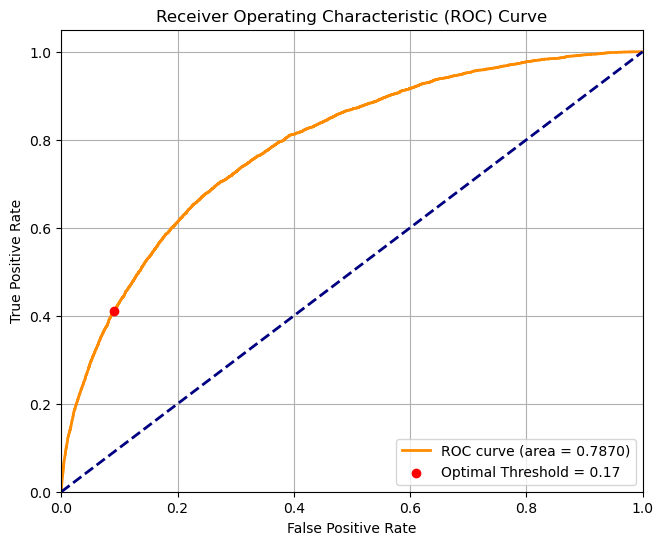

 
-----------------------------------------------------------------------------------------------------------------------------
 


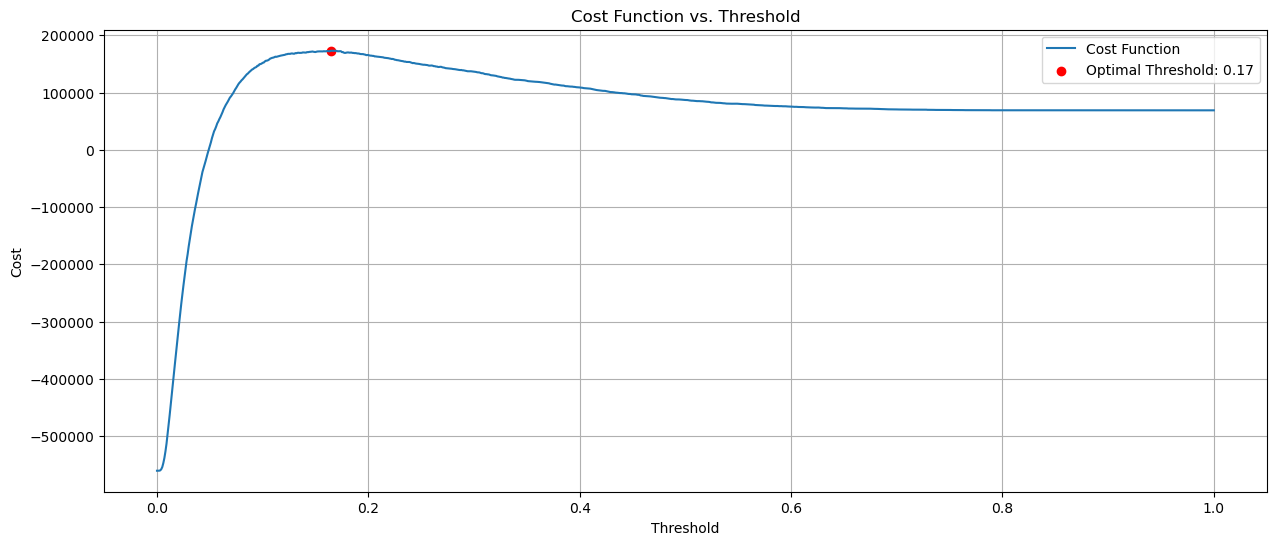

In [61]:
roc_auc_model1, max_cost_model1, optimal_threshold_model1 = graph_results(y_prob)

In [62]:
optimal_threshold = optimal_threshold_model1

y_pred = (y_prob >= optimal_threshold).astype(int)

In [63]:
# saving model
with open('xgb_clf.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

# Saving threshold
with open('optimal_threshold.pkl', 'wb') as file:
    pickle.dump(optimal_threshold, file)

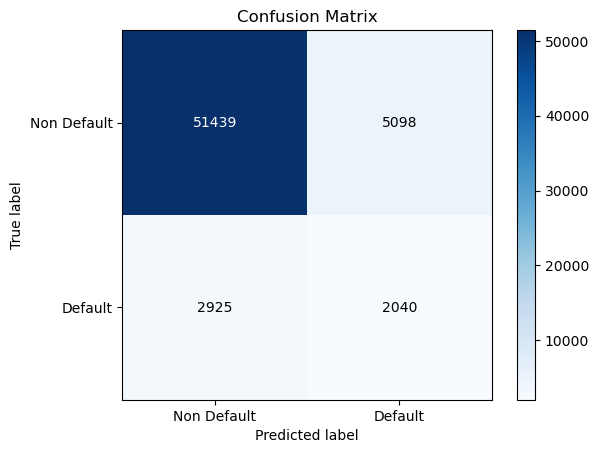

In [64]:
cm = confusion_matrix(y_test, y_pred) 

display_labels = ["Non Default", "Default"]  

# Confusion matrix
fig, ax = plt.subplots()
cmap = plt.cm.Blues 
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
tick_marks = np.arange(len(display_labels))
plt.xticks(tick_marks, display_labels)
plt.yticks(tick_marks, display_labels)

# Display
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### 4.2 Feature Importance globale - SHAP

In [65]:
# sampling
X_test_df = pd.DataFrame(X_test, columns=feature_names)

sample_data_df = X_test_df

In [66]:
explainer= shap.TreeExplainer(xgb_clf)
shap_values = explainer(sample_data_df)

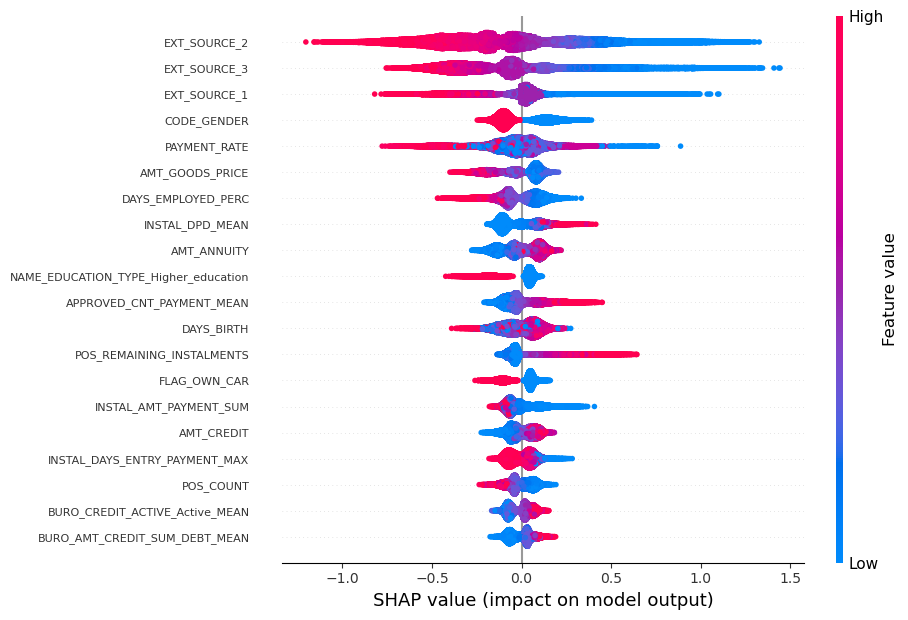

In [67]:
shap.summary_plot(shap_values, sample_data_df, show=False)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=8)
plt.gcf().set_size_inches(15,6)
plt.show()

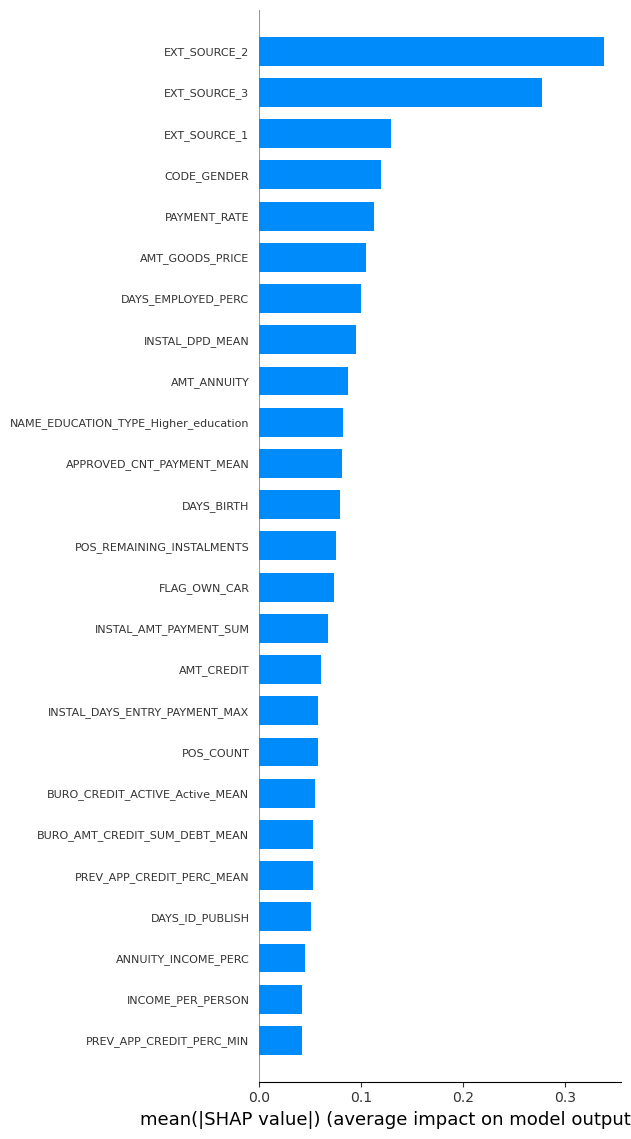

In [68]:
# Plot 
shap.summary_plot(shap_values, sample_data_df, max_display=25, plot_type="bar", show=False)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=8) 
plt.show()

### 4.3 Feature Importance locale - SHAP

 
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 0
 
Default Probability : 0.039
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


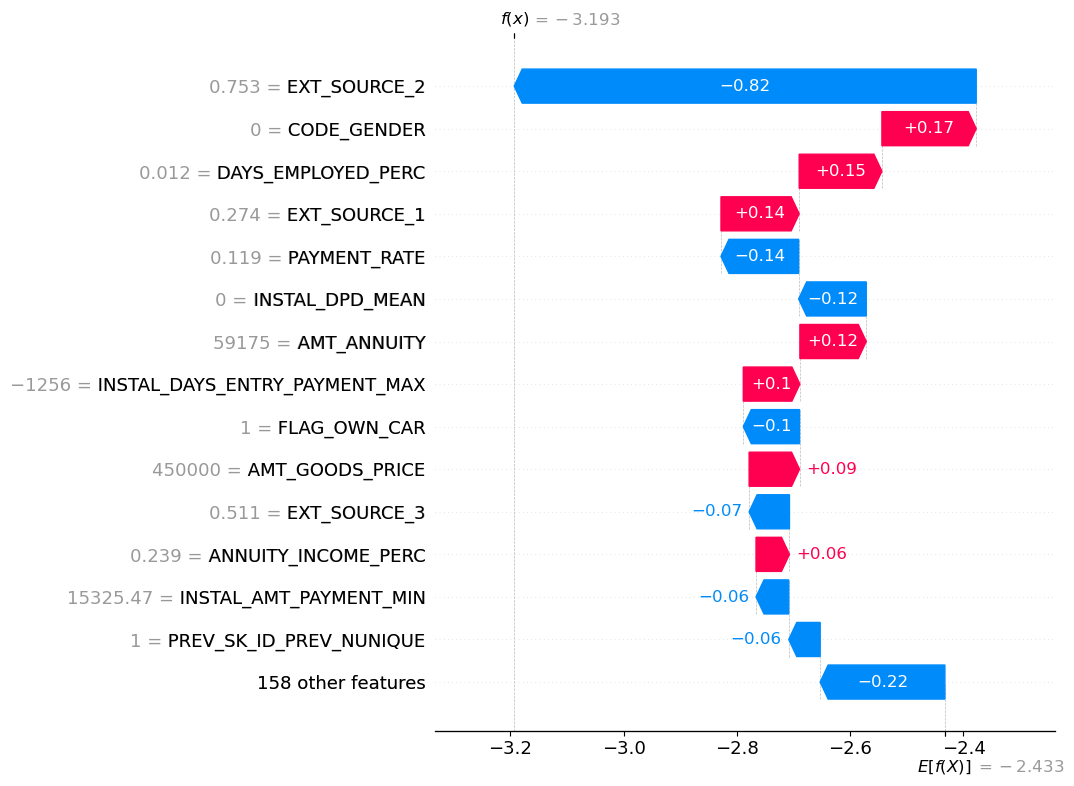

In [69]:
# index to explain :
idx= 0


print(' ')
print('-'*120)
print(' ')
print('Client ID :', sample_data_df.iloc[idx].name)
print(' ')
print('Default Probability :', y_prob[idx].round(3))
print(' ')
if y_pred[idx] == 0:
    print('Credit approved: Yes')
else:
    print('Credit approved: No')
    
print(' ')
print('-'*120)
print(' ') 

print(' ')
print('EXPLANATION :')
print(' ')

shap.plots.waterfall(shap_values[idx], max_display=15)

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 50
 
Default Probability : 0.047
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


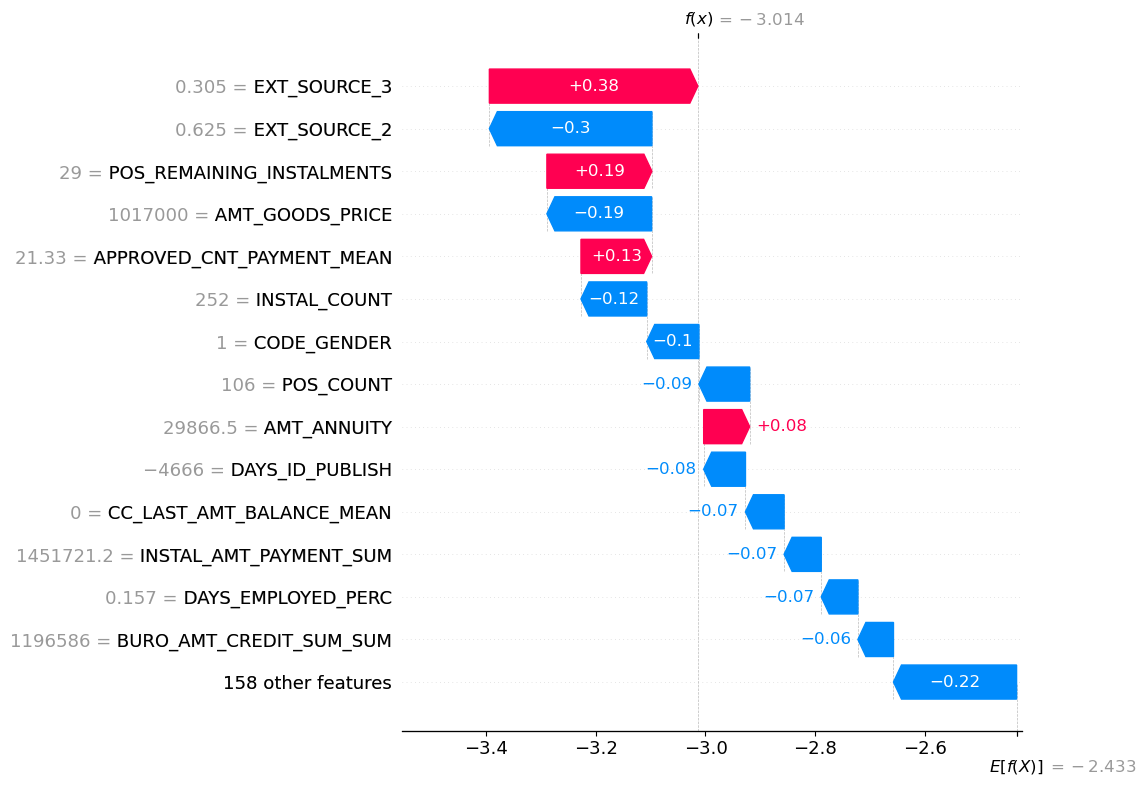

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 51
 
Default Probability : 0.3
 
Credit approved: No
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


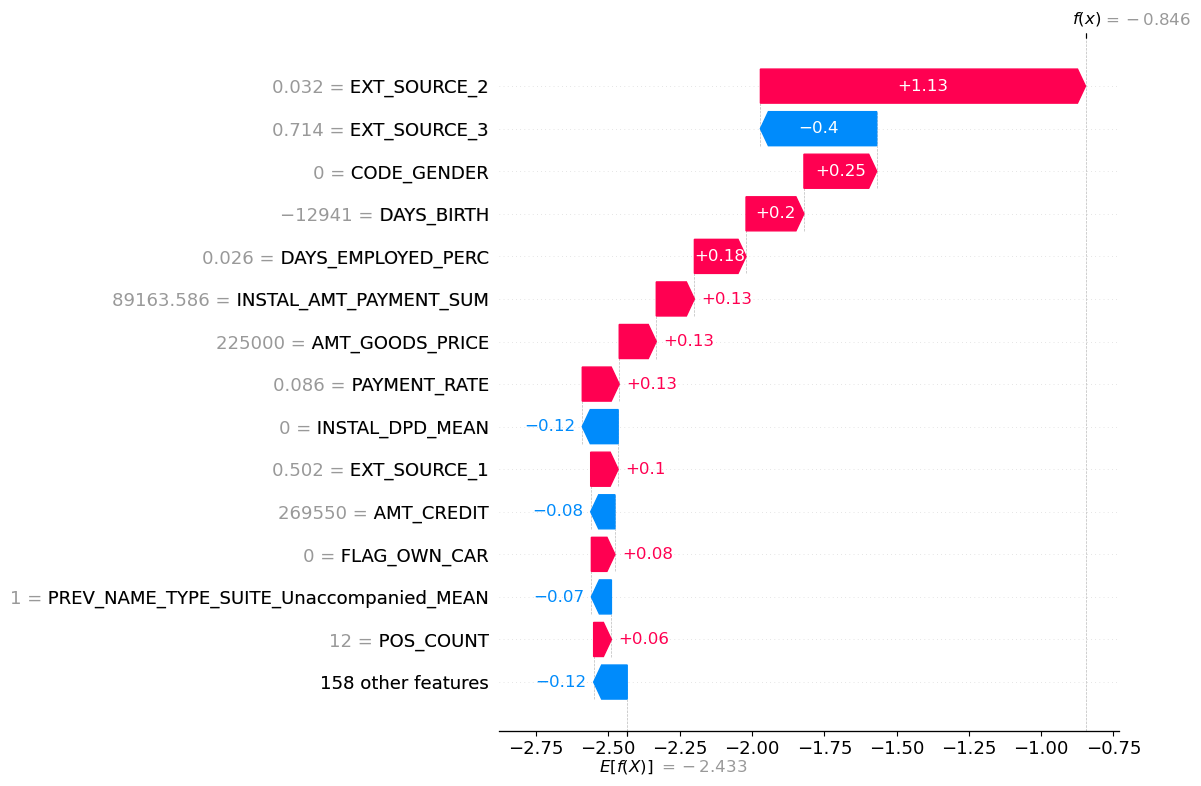

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 52
 
Default Probability : 0.063
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


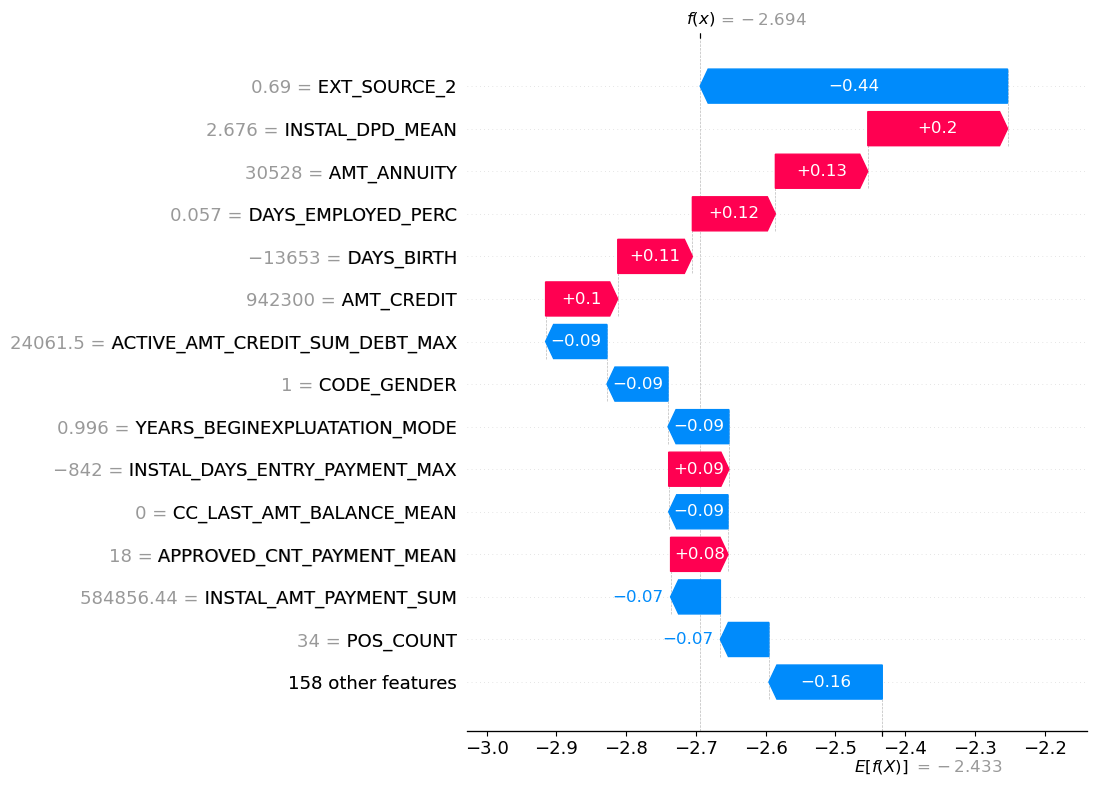

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 53
 
Default Probability : 0.013
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


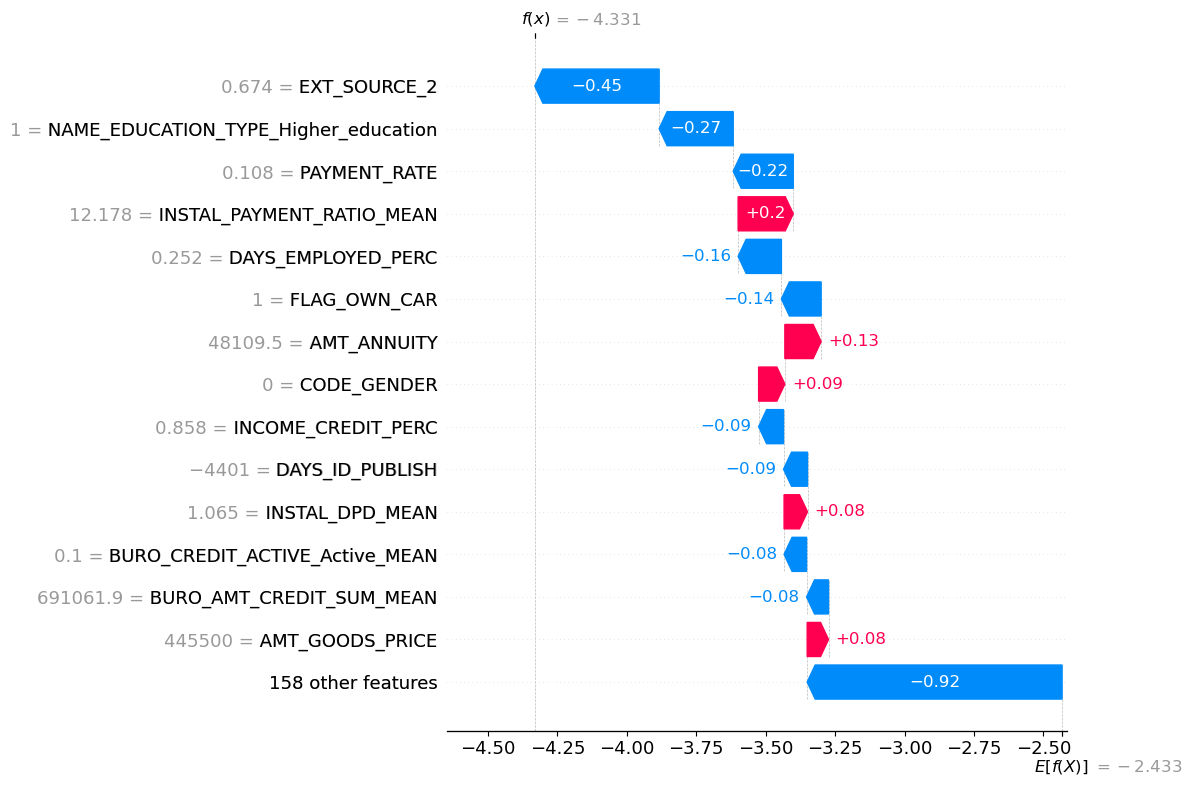

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 54
 
Default Probability : 0.099
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


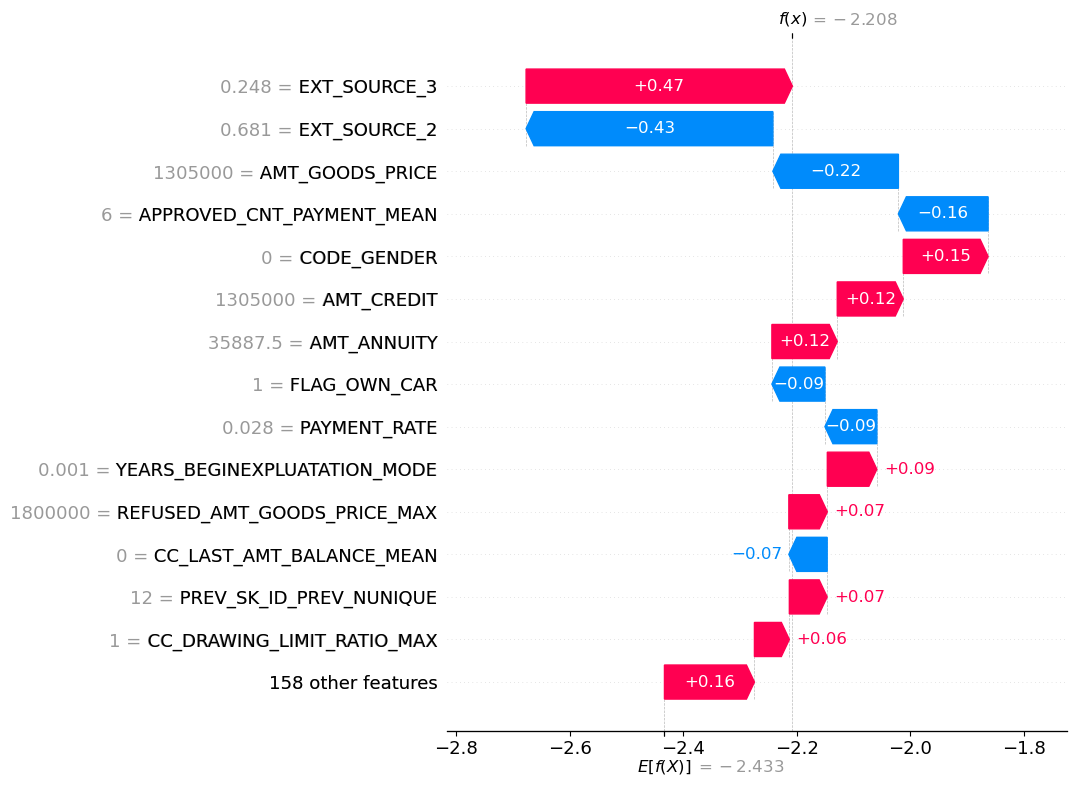

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 55
 
Default Probability : 0.018
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


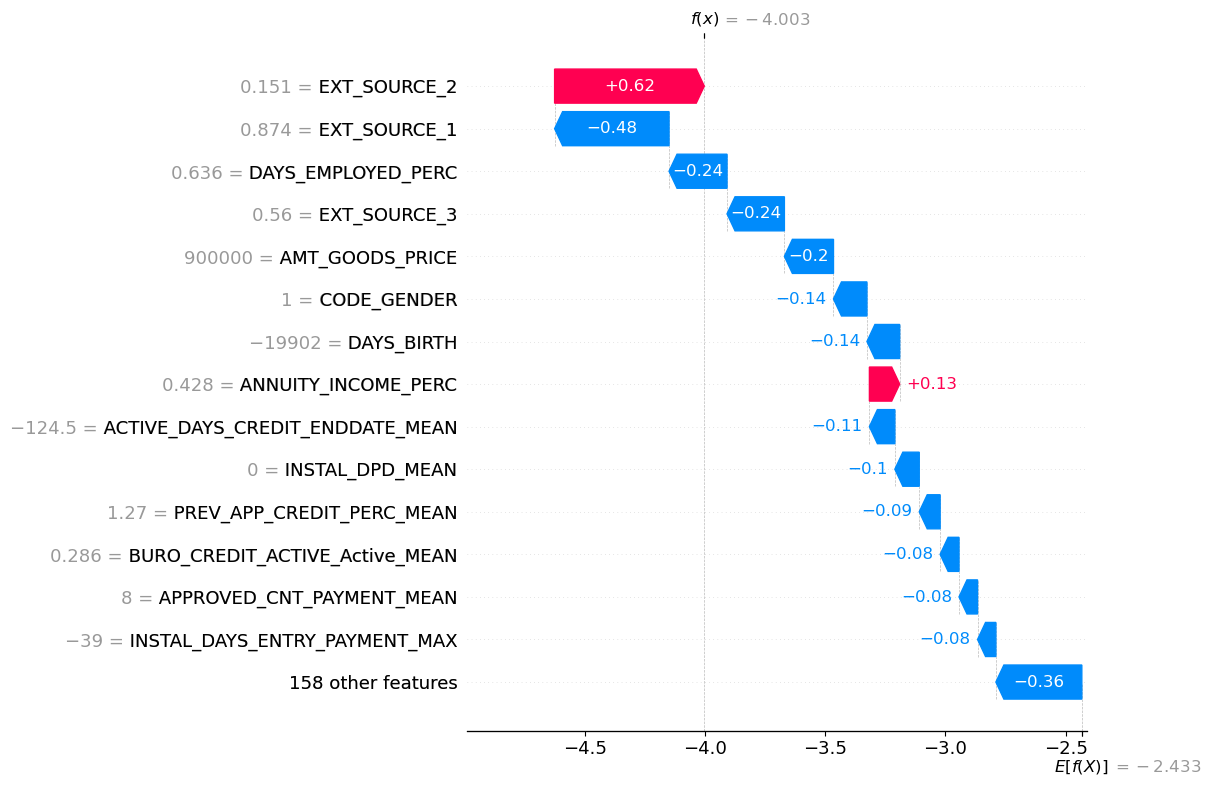

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 56
 
Default Probability : 0.184
 
Credit approved: No
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


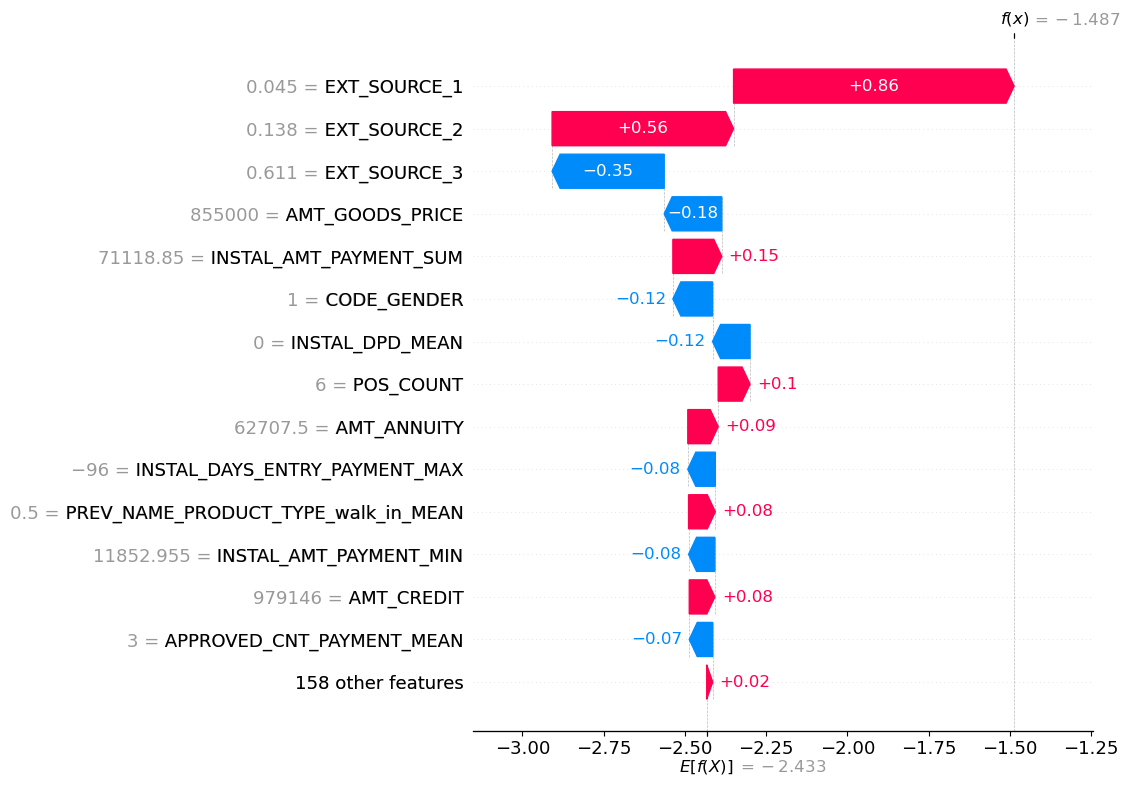

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 57
 
Default Probability : 0.312
 
Credit approved: No
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


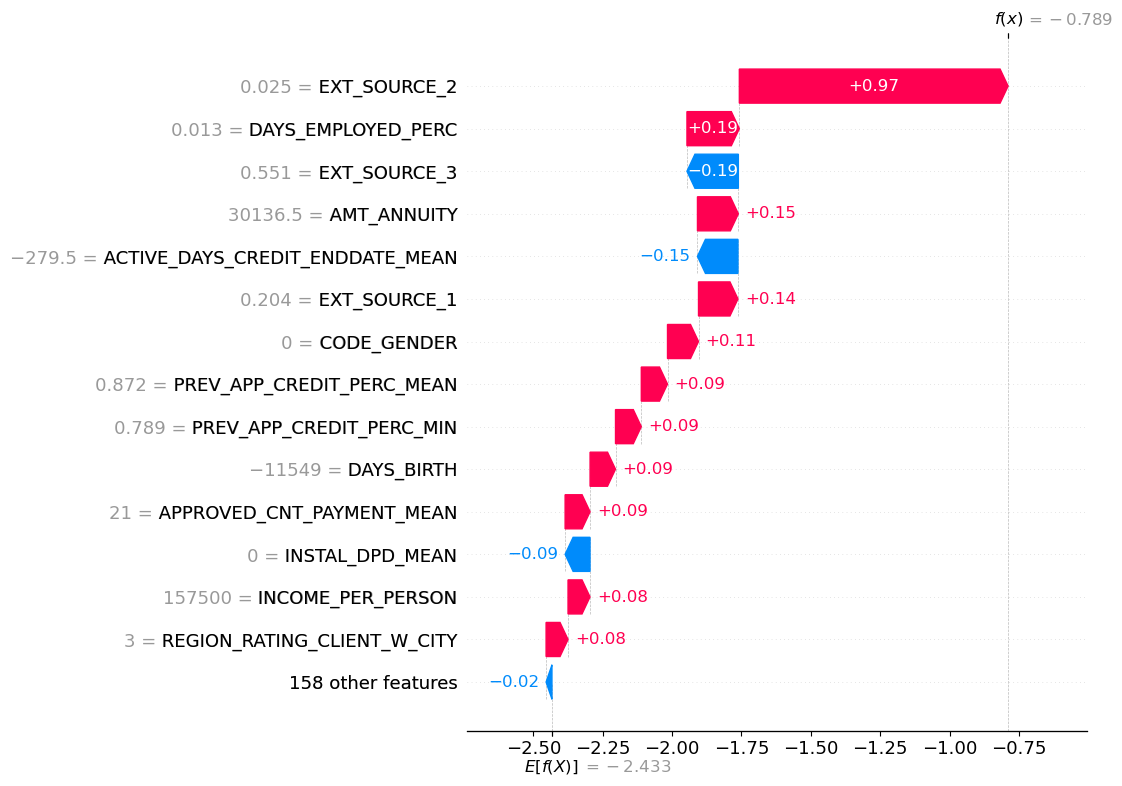

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 58
 
Default Probability : 0.013
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


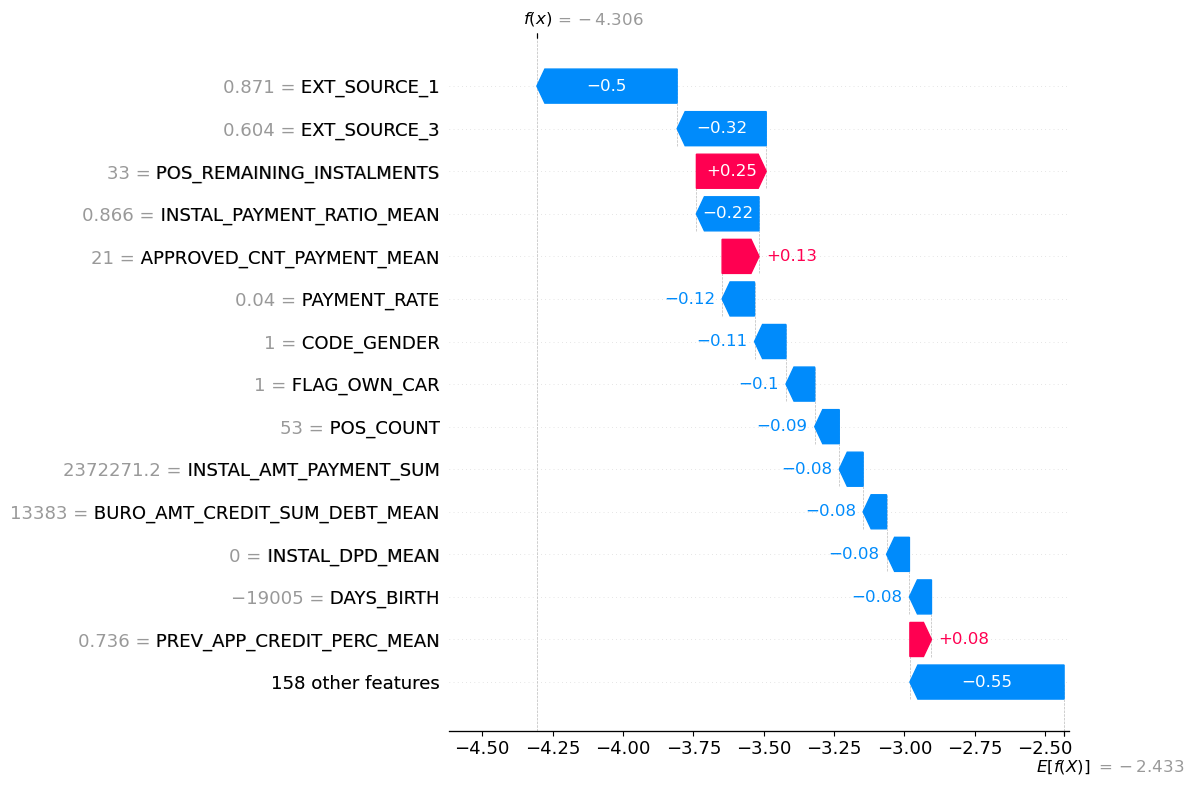

 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 
Client ID : 59
 
Default Probability : 0.008
 
Credit approved: Yes
 
------------------------------------------------------------------------------------------------------------------------
 
 
EXPLANATION :
 


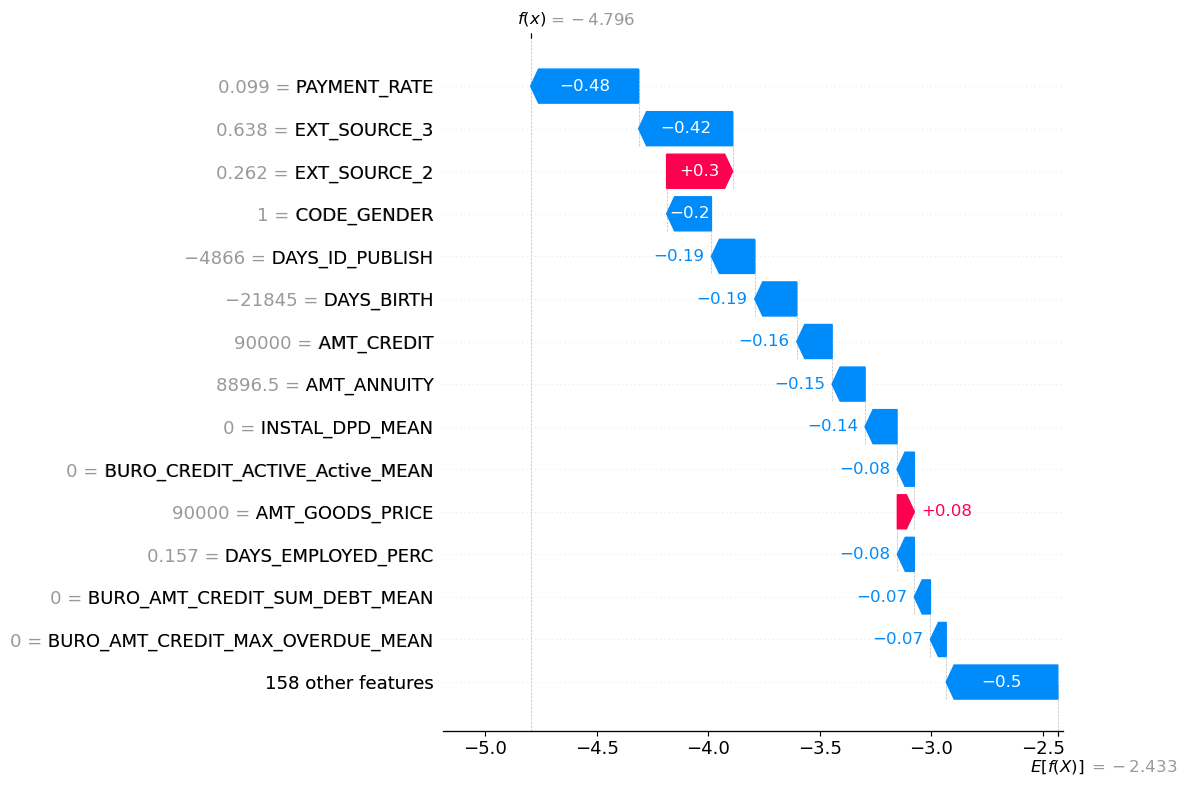

In [70]:
for idx in range(50, 60):
    print(' ')
    print('-'*120)
    print('-'*120)
    print('-'*120)
    print(' ')
    print('Client ID :', sample_data_df.iloc[idx].name)
    print(' ')
    print('Default Probability :', y_prob[idx].round(3))
    print(' ')
    if y_pred[idx] == 0:
        print('Credit approved: Yes')
    else:
        print('Credit approved: No')

    print(' ')
    print('-'*120)
    print(' ') 

    print(' ')
    print('EXPLANATION :')
    print(' ')

    shap.plots.waterfall(shap_values[idx], max_display=15)